In [1]:
import re
import ast
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import keras

from collections import Counter

from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD, IncrementalPCA
from scipy.sparse import csr_matrix, lil_matrix
import scipy
from itertools import chain
import statistics
from sklearn.pipeline import make_pipeline
from sklearn.utils import class_weight
from sklearn import svm, preprocessing
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from numpy import expand_dims

from tensorflow.keras.utils import to_categorical
from tensorflow import concat
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import tensorflow
import os
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras import applications
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt
from keras.applications.vgg19 import preprocess_input
from tensorflow.image import rgb_to_grayscale, grayscale_to_rgb
from tensorflow import tile
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
image_size = 224
input_shape = (image_size, image_size, 3)

2022-11-18 22:38:35.599499: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-18 22:38:35.599553: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# importation des données

categories = os.listdir('Dessins_humains/')
categories.remove('.ipynb_checkpoints')
drawings = []
labels = list()

for folder in categories:
    tmp_repertory = 'Dessins_humains/' + folder
    #print(folder)
    for img in os.listdir(tmp_repertory):
        if not img.startswith('.'):
            labels.append(folder)
            img = load_img(tmp_repertory + '/' + img, target_size=(224,224,3))
            img = img_to_array(img)
            img = expand_dims(img,axis=0)
            img = preprocess_input(img)
            img = np.array(img)
            img = np.reshape(img, (224,224,3))
            drawings.append(img)

In [3]:
def preprocess_data(groupes):
    nb_groupes = len(groupes)

    labels_groupes = {}
    index_groupes = {}

    for groupe in list(groupes.keys()): # pour chaque groupe
        labels_groupes[groupe] = [labels[j] for j,x in enumerate(labels) if x in groupes[groupe]]
        index_groupes[groupe] = [j for j,x in enumerate(labels) if x in groupes[groupe]]

    index_length = [len(index_groupes[groupe]) for groupe in groupes]

    for groupe, nb_dessins in zip(list(groupes.keys()), index_length):
        print(f'{groupe} : {nb_dessins}')

    labels_index = sorted(sum(list(index_groupes.values()), []))

    labels_names = []
    drawings_new = []
    for i in tqdm(labels_index):
        labels_names.append(labels[i])
        drawings_new.append(drawings[i])

    labels_final = [''] * len(labels_names)

    for i in range(len(labels_final)):
        for grp_index in range(len(list(groupes.keys()))):
            if labels_names[i] in list(groupes.values())[grp_index]:
                labels_final[i] = list(groupes.keys())[grp_index]
    return drawings_new, labels_final, labels_names

#### model_dict

In [5]:
enfants = ['Crèche','PS','MS','GS','CE1','CE2','CM1','CM2']
adultes = ['NOV','EXP']

data_augmentation = tf.keras.Sequential(
    [       tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
    ]
)

# pour chaque couple de catégories d'enfants
for i in range(len(enfants)-1):
    print(enfants[i:i+2])
    enfants_groupe = enfants[i:i+2]
    # si le modèle n'a pas tourné 10 fois :
    if '10_best_models_acc.txt' not in os.listdir('models/' + str(enfants_groupe[0] + enfants_groupe[1]) + '/'):
        scores = [] # pour CrèchePS vs NOVEXP, va contenir l'accuracy de 10 fois le même modèle qui a tourné
        groupes = {enfants_groupe[0]+enfants_groupe[1]:enfants_groupe, adultes[0]+adultes[1]:adultes}
        drawings_new, labels_final, labels_names = preprocess_data(groupes)
        drawings_new = np.reshape(drawings_new,(len(drawings_new),224,224,3))
        for label_idx in range(len(labels_final)):
            if labels_final[label_idx] != 'NOVEXP':
                labels_final[label_idx] = '0' + labels_final[label_idx]
            else:
                labels_final[label_idx] = '1' + labels_final[label_idx]
        le = LabelEncoder()
        labels_final = le.fit_transform(labels_final)
        X_train, X_val, Y_train, Y_val = train_test_split(drawings_new,labels_final, test_size = 0.2, random_state = 42)
        with open('models/' + enfants_groupe[0] + enfants_groupe[1] +'/models_scores.txt') as f:
            lines = f.readlines()
        model_dict = ast.literal_eval(lines[1])
        for num_model in range(10): # on fait tourner 10 fois le modèle en repartant de 0
            inputs = tf.keras.Input(shape=(224,224,3))
            inputs = data_augmentation(inputs)
            pool_value = model_dict['pool_value']
            if pool_value == 'None':
                pool_value = None
            x = keras.applications.vgg19.VGG19(
                input_tensor=inputs,
                include_top=False,
                pooling=pool_value,
                weights='imagenet'
            )
            x.trainable = False
            x = Flatten()(x.output)
            x = Dropout(model_dict['dropout'])(x)
            # avoir le nombre de FC layers
            num_layers = model_dict['num_layers']
            for num_layer in range(num_layers):
                # Tune the number of neurons in each layer
                len_units = model_dict['units_' + str(num_layer)]
                x = Dense(len_units)(x)
                if num_layer==0 and model_dict['BatchNorm'] == True:
                    x = BatchNormalization()(x)
                x = Activation('relu')(x)
            outputs = Dense(1, activation='sigmoid')(x)
            model = Model(inputs,outputs)
            learning_rate = model_dict['lr']
            model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(learning_rate),
                  metrics=['accuracy'])

            early_stop = tf.keras.callbacks.EarlyStopping(
                            monitor = 'val_loss',
                            patience = 3, ##############################################
                            restore_best_weights = True)
            class_weights = class_weight.compute_class_weight(
                                    class_weight = "balanced",
                                    classes = np.unique(Y_train),
                                    y = Y_train                                                    
                                )
            class_weight_dict = dict(enumerate(class_weights))
            history = model.fit(X_train,Y_train, epochs=15, validation_data=(X_val,Y_val), ############################
                    callbacks = [early_stop], batch_size = model_dict['batch_size'], class_weight = class_weight_dict)
            epoch_val_loss_min = np.argmin(history.history['val_loss'])
            val_max = history.history['val_accuracy'][epoch_val_loss_min]
            scores.append(val_max)
        with open('models/' + str(enfants_groupe[0] + enfants_groupe[1]) + '/' + '10_best_models_acc.txt', 'a') as f:
            f.writelines(str(scores))

['Crèche', 'PS']
['PS', 'MS']
PSMS : 79
NOVEXP : 84


100%|██████████| 163/163 [00:00<00:00, 341153.47it/s]


Epoch 1/15
3/3 [==============================] - 25s 7s/step - loss: 0.7482 - accuracy: 0.5769 - val_loss: 2.2209 - val_accuracy: 0.5152
Epoch 2/15
3/3 [==============================] - 24s 7s/step - loss: 0.6473 - accuracy: 0.6462 - val_loss: 1.1749 - val_accuracy: 0.5455
Epoch 3/15
3/3 [==============================] - 24s 7s/step - loss: 0.6626 - accuracy: 0.6000 - val_loss: 0.9486 - val_accuracy: 0.5758
Epoch 4/15
3/3 [==============================] - 24s 7s/step - loss: 0.5931 - accuracy: 0.7385 - val_loss: 0.5076 - val_accuracy: 0.7273
Epoch 5/15
3/3 [==============================] - 24s 7s/step - loss: 0.5821 - accuracy: 0.6692 - val_loss: 0.4663 - val_accuracy: 0.6970
Epoch 6/15
3/3 [==============================] - 24s 7s/step - loss: 0.5318 - accuracy: 0.7769 - val_loss: 0.7012 - val_accuracy: 0.6364
Epoch 7/15
3/3 [==============================] - 24s 7s/step - loss: 0.5187 - accuracy: 0.7538 - val_loss: 0.5978 - val_accuracy: 0.6364
Epoch 8/15
3/3 [==================

100%|██████████| 164/164 [00:00<00:00, 449291.87it/s]


Epoch 1/15
9/9 [==============================] - 26s 3s/step - loss: 0.6558 - accuracy: 0.5649 - val_loss: 0.7297 - val_accuracy: 0.6364
Epoch 2/15
9/9 [==============================] - 24s 3s/step - loss: 0.4982 - accuracy: 0.8779 - val_loss: 0.6358 - val_accuracy: 0.6364
Epoch 3/15
9/9 [==============================] - 24s 3s/step - loss: 0.4080 - accuracy: 0.9008 - val_loss: 0.6560 - val_accuracy: 0.5758
Epoch 4/15
9/9 [==============================] - 24s 3s/step - loss: 0.2663 - accuracy: 0.9389 - val_loss: 0.5566 - val_accuracy: 0.6970
Epoch 5/15
9/9 [==============================] - 24s 3s/step - loss: 0.1750 - accuracy: 0.9695 - val_loss: 0.5573 - val_accuracy: 0.7879
Epoch 6/15
9/9 [==============================] - 24s 3s/step - loss: 0.1160 - accuracy: 0.9771 - val_loss: 0.5219 - val_accuracy: 0.7273
Epoch 7/15
9/9 [==============================] - 24s 3s/step - loss: 0.0793 - accuracy: 0.9771 - val_loss: 0.6726 - val_accuracy: 0.6970
Epoch 8/15
9/9 [==================

100%|██████████| 167/167 [00:00<00:00, 490854.08it/s]


Epoch 1/15
9/9 [==============================] - 26s 3s/step - loss: 0.6727 - accuracy: 0.6316 - val_loss: 0.7774 - val_accuracy: 0.6765
Epoch 2/15
9/9 [==============================] - 25s 3s/step - loss: 0.4996 - accuracy: 0.8571 - val_loss: 0.8491 - val_accuracy: 0.7647
Epoch 3/15
9/9 [==============================] - 25s 3s/step - loss: 0.2985 - accuracy: 0.9248 - val_loss: 0.9141 - val_accuracy: 0.5588
Epoch 4/15
9/9 [==============================] - 25s 3s/step - loss: 0.1634 - accuracy: 0.9699 - val_loss: 1.1777 - val_accuracy: 0.6765
Epoch 1/15
9/9 [==============================] - 26s 3s/step - loss: 0.6922 - accuracy: 0.5338 - val_loss: 0.7179 - val_accuracy: 0.5588
Epoch 2/15
9/9 [==============================] - 25s 3s/step - loss: 0.4979 - accuracy: 0.8271 - val_loss: 0.9926 - val_accuracy: 0.6176
Epoch 3/15
9/9 [==============================] - 25s 3s/step - loss: 0.2972 - accuracy: 0.9248 - val_loss: 1.0480 - val_accuracy: 0.7353
Epoch 4/15
9/9 [==================

100%|██████████| 162/162 [00:00<00:00, 324642.74it/s]


Epoch 1/15
9/9 [==============================] - 25s 3s/step - loss: 0.6596 - accuracy: 0.6202 - val_loss: 1.0532 - val_accuracy: 0.6667
Epoch 2/15
9/9 [==============================] - 24s 3s/step - loss: 0.3867 - accuracy: 0.9147 - val_loss: 1.1563 - val_accuracy: 0.5758
Epoch 3/15
9/9 [==============================] - 24s 3s/step - loss: 0.1784 - accuracy: 0.9457 - val_loss: 1.4807 - val_accuracy: 0.5455
Epoch 4/15
9/9 [==============================] - 24s 3s/step - loss: 0.0681 - accuracy: 1.0000 - val_loss: 1.2715 - val_accuracy: 0.6061
Epoch 1/15
9/9 [==============================] - 26s 3s/step - loss: 0.6738 - accuracy: 0.5736 - val_loss: 0.6523 - val_accuracy: 0.6667
Epoch 2/15
9/9 [==============================] - 24s 3s/step - loss: 0.4421 - accuracy: 0.8605 - val_loss: 1.0659 - val_accuracy: 0.6970
Epoch 3/15
9/9 [==============================] - 24s 3s/step - loss: 0.2189 - accuracy: 0.9457 - val_loss: 1.2069 - val_accuracy: 0.6667
Epoch 4/15
9/9 [==================

100%|██████████| 160/160 [00:00<00:00, 492361.44it/s]


Epoch 1/15
8/8 [==============================] - 25s 3s/step - loss: 4.3259 - accuracy: 0.5391 - val_loss: 0.6954 - val_accuracy: 0.5312
Epoch 2/15
8/8 [==============================] - 24s 3s/step - loss: 0.6765 - accuracy: 0.5859 - val_loss: 0.6900 - val_accuracy: 0.5938
Epoch 3/15
8/8 [==============================] - 24s 3s/step - loss: 0.6078 - accuracy: 0.6406 - val_loss: 0.7053 - val_accuracy: 0.5625
Epoch 4/15
8/8 [==============================] - 24s 3s/step - loss: 0.6527 - accuracy: 0.6328 - val_loss: 0.7172 - val_accuracy: 0.5938
Epoch 5/15
8/8 [==============================] - 24s 3s/step - loss: 0.5562 - accuracy: 0.6875 - val_loss: 0.6626 - val_accuracy: 0.6875
Epoch 6/15
8/8 [==============================] - 23s 3s/step - loss: 0.7195 - accuracy: 0.6641 - val_loss: 0.7209 - val_accuracy: 0.5000
Epoch 7/15
8/8 [==============================] - 23s 3s/step - loss: 0.5876 - accuracy: 0.6875 - val_loss: 1.8281 - val_accuracy: 0.4688
Epoch 8/15
8/8 [==================

100%|██████████| 169/169 [00:00<00:00, 634022.70it/s]


Epoch 1/15
9/9 [==============================] - 27s 3s/step - loss: 0.7007 - accuracy: 0.5778 - val_loss: 0.7945 - val_accuracy: 0.6765
Epoch 2/15
9/9 [==============================] - 25s 3s/step - loss: 0.5094 - accuracy: 0.7630 - val_loss: 0.7644 - val_accuracy: 0.6471
Epoch 3/15
9/9 [==============================] - 25s 3s/step - loss: 0.4961 - accuracy: 0.7481 - val_loss: 0.9385 - val_accuracy: 0.6176
Epoch 4/15
9/9 [==============================] - 26s 3s/step - loss: 0.4654 - accuracy: 0.7704 - val_loss: 1.2247 - val_accuracy: 0.4706
Epoch 5/15
9/9 [==============================] - 27s 3s/step - loss: 0.3641 - accuracy: 0.8222 - val_loss: 0.9359 - val_accuracy: 0.5882
Epoch 1/15
9/9 [==============================] - 27s 3s/step - loss: 0.6642 - accuracy: 0.6222 - val_loss: 1.0444 - val_accuracy: 0.7059
Epoch 2/15
9/9 [==============================] - 25s 3s/step - loss: 0.6676 - accuracy: 0.6519 - val_loss: 0.8092 - val_accuracy: 0.6765
Epoch 3/15
9/9 [==================

In [6]:
mean_acc = []
scores_dict = {}
for i in range(len(enfants)-1):
    enfants_groupe = enfants[i:i+2]
    with open('models/' + enfants_groupe[0] + enfants_groupe[1] +'/10_best_models_acc.txt') as f:
        lines = f.readlines()[0]
    tmp_acc = ast.literal_eval(lines)
    scores_dict[enfants_groupe[0] + enfants_groupe[1]] = tmp_acc
  #  mean_acc.append(float(lines).mean)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9d30925a00>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9d309252b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9d30925850>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9d3092bbe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9d3092be50>],
 'means': []}

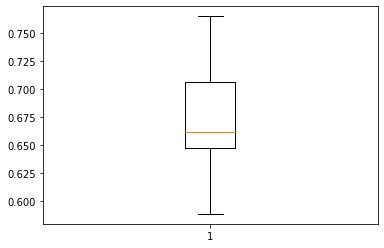

In [7]:
plt.boxplot(ast.literal_eval(lines))

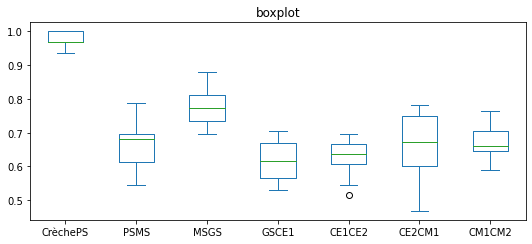

In [8]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
data = pd.DataFrame(scores_dict)

# Plot the dataframe
ax = data[scores_dict.keys()].plot(kind='box', title='boxplot')

# Display the plot
plt.show()